# Classroom 6 - Training a Named Entity Recognition Model with a LSTM

The classroom today is primarily geared towards preparing you for Assignment 4 which you'll be working on after today. The notebook is split into three main parts to get you thinking. You should work through these sections in groups together in class. 

If you have any questions or things you don't understand, make a note of them so you can remember to ask - or, even better, post them to Slack!

If you get through everything here, make a start on the assignment. If you don't, dont' worry about it - but I suggest you finish all of the exercises here before starting the assignment.

## 1. A very short intro to NER
Named entity recognition (NER) also known as named entity extraction, and entity identification is the task of tagging an entity is the task of extracting which seeks to extract named entities from unstructured text into predefined categories such as names, medical codes, quantities or similar.

The most common variant is the [CoNLL-20003](https://www.clips.uantwerpen.be/conll2003/ner/) format which uses the categories, person (PER), organization (ORG) location (LOC) and miscellaneous (MISC), which for example denote cases such nationalies. For example:

*Hello my name is $Ross_{PER}$ I live in $Aarhus_{LOC}$ and work at $AU_{ORG}$.*

For example, let's see how this works with ```spaCy```. NB: you might need to remember to install a ```spaCy``` model:

```python -m spacy download en_core_web_sm```

In [1]:
import os
os.system('pip install --upgrade pip spacy datasets torch gensim')
os.system('python3 -m spacy download en_core_web_sm')
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("Hello my name is Ross. I live in Denmark and work at Aarhus University, I am Scottish and today is Friday 27th.")

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.9/441.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.9/815.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 101.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 kB 592.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.7/490.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 604.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from spacy import displacy
displacy.render(doc, style="ent")

## Tagging standards
There exist different tag standards for NER. The most used one is the BIO-format which frames the task as token classification denoting inside, outside and beginning of a token. 

Words marked with *O* are not a named entity. Words with NER tags which start with *B-\** indicate the start of a multiword entity (i.e. *B-ORG* for the *Aarhus* in *Aarhus University*), while *I-\** indicate the continuation of a token (e.g. University).

    B = Beginning
    I = Inside
    O = Outside

<details>
<summary>Q: What other formats and standards are available? What kinds of entities do they make it possible to tag?</summary>
<br>
You can see more examples on the spaCy documentation for their [different models(https://spacy.io/models/en)
</details>


In [3]:
for t in doc:
    if t.ent_type:
        print(t, f"{t.ent_iob_}-{t.ent_type_}")
    else:
        print(t, t.ent_iob_)

Hello O
my O
name O
is O
Ross B-PERSON
. O
I O
live O
in O
Denmark B-GPE
and O
work O
at O
Aarhus B-ORG
University I-ORG
, O
I O
am O
Scottish B-NORP
and O
today B-DATE
is O
Friday B-DATE
27th I-DATE
. O


### Some challenges with NER
While NER is currently framed as above this formulating does contain some limitations. 

For instance the entity Aarhus University really refers to both the location Aarhus, the University within Aarhus, thus nested NER (N-NER) argues that it would be more correct to tag it in a nested fashion as \[\[$Aarhus_{LOC}$\] $University$\]$_{ORG}$ (Plank, 2020). 

Other task also include named entity linking. Which is the task of linking an entity to e.g. a wikipedia entry, thus you have to both know that it is indeed an entity and which entity it is (if it is indeed a defined entity).

In this assignment, we'll be using Bi-LSTMs to train an NER model on a predifined data set which uses IOB tags of the kind we outlined above.

## 2. Training in batches

When you trained your document classifier for the last assignment, you probably noticed that the neural network was quite brittle. Small changes in the hyperparameters could cause massive changes in performance. Likewise, you probably noticed that they tend to substantially overfit the training data and underperform on the validation and test data.

One way we can get around this is by processing the data in smaller chunks known as *batches*. 

<details>
<summary>Q: Why might it be a good idea to train on batches, rather than the whole dataset?</summary>
<br>
These batches are usually small (something like 32 instances at a time) but they have couple of important effects on training:

- Batches can be processed in parallel, rather the sequentially. This can result in substantial speed up from computational perspective
- Similarly, smaller batch sizes make it easier to fit training data into memory
- Lastly,  smaller batch sizes are noisy, meaning that they have a regularizing effect and thus lead to less overfitting.

In this assignment, we're going to be using batches of data to train our NER model. To do that, we first have to prepare our batches for training. You can read more about batching in [this blog post](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/).

</details>



* When having large amounts of data it is a good idea to perform batch processing as loading in smaller parts of the data saves memory

In [1]:
# this allows us to look one step up in the directory
# for importing custom modules from src
import sys
sys.path.append("..")
from src.util import batch
from src.LSTM import RNN
from src.embedding import gensim_to_torch_embedding

# numpy and pytorch
import numpy as np
import torch
from torch import nn

# loading data and embeddings
from datasets import load_dataset
import gensim.downloader as api

We can download the datset using the ```load_dataset()``` function we've already seen. Here we take only the training data.

When you've downloaded the dataset, you're welcome to save a local copy so that we don't need to constantly download it again everytime the code runs.

Q: What do the ```train.features``` values refer to?

* As far as I understand different taggings of the words

In [2]:
# DATASET
dataset = load_dataset("conllpp")
train = dataset["train"]

# inspect the dataset
train["tokens"][:1]
train["ner_tags"][:1]

# get number of classes
num_classes = train.features["ner_tags"].feature.num_classes

Found cached dataset conllpp (/home/coder/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
train.features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

In [7]:
print(train["tokens"][:1]
)
print(train["ner_tags"][:1]
)


[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']]
[[3, 0, 7, 0, 0, 0, 7, 0, 0]]


We then use ```gensim``` to get some pretrained word embeddings for the input layer to the model. 

In this example, we're going to use a GloVe model pretrained on Wikipedia, with 50 dimensions.

I've provided a helper function to take the ```gensim``` embeddings and prepare them for ```pytorch```.

In [3]:
from src.embedding import gensim_to_torch_embedding
import importlib

# CONVERTING EMBEDDINGS
model = api.load("glove-wiki-gigaword-50")

# convert gensim word embedding to torch word embedding
embedding_layer, vocab = gensim_to_torch_embedding(model)
# this word embedding has 50 dimensions

50
[[-0.12920076 -0.28866628 -0.01224866 -0.05676644 -0.20210965 -0.08389011
   0.33359843  0.16045167  0.03867431  0.17833012  0.04696583 -0.00285802
   0.29099807  0.04613704 -0.20923874 -0.06613114 -0.06822549  0.07665912
   0.3134014   0.17848536 -0.1225775  -0.09916984 -0.07495987  0.06413227
   0.14441176  0.60894334  0.17463093  0.05335403 -0.01273871  0.03474107
  -0.8123879  -0.04688699  0.20193407  0.2031118  -0.03935686  0.06967544
  -0.01553638 -0.03405238 -0.06528071  0.12250231  0.13991883 -0.17446303
  -0.08011883  0.0849521  -0.01041659 -0.13705009  0.20127155  0.10069408
   0.00653003  0.01685157]]
(1, 50)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
(1, 50)
embedding
[[ 0.41800001  0.24968    -0.41242    ... -0.18411    -0.11514
  -0.78580999]
 [ 0.013441    0.23682    -0.16899    ... -0.56656998  0.044691
   0.30392   ]
 [ 0.15164     0.30177    -0.16763  

In [9]:
embedding_layer # the embedding layer basically contains the vector re-presentation for all words in the vocabulary along with a vector for unknown and pad 

Embedding(400002, 50, padding_idx=400001)

### Preparing a batch

The first thing we want to do is to shuffle our dataset before training. 

Why might it be a good idea to shuffle the data?

* To ensure generalisability by avoiding bias in the splits

In [10]:
# shuffle dataset
shuffled_train = dataset["train"].shuffle(seed=1)
len(shuffled_train["tokens"])/32

438.78125

Next, we want to bundle the shuffled training data into smaller batches of predefined size. I've written a small utility function here to help. 

<details>
<summary>Q: Can you explain how the ```batch()``` function works?</summary>
<br>
 Hint: Check out [this link](https://realpython.com/introduction-to-python-generators/).
</details>



In [11]:
batch_size = 32
batches_tokens = batch(shuffled_train["tokens"], batch_size)
batches_tags = batch(shuffled_train["ner_tags"], batch_size)

Next, we want to use the ```tokens_to_idx()``` function below on our batches.

<details>
<summary>Q: What is this function doing? Why is it doing it?</summary>
<br>
We're making everything lowercase and adding a new, arbitrary token called <UNK> to the vocabulary. This <UNK> means "unknown" and is used to replace out-of-vocabulary tokens in the data - i.e. tokens that don't appear in the vocabulary of the pretrained word embeddings.
</details>


In [12]:
def tokens_to_idx(tokens, vocab=model.key_to_index):
    """ This function finds a the index of a specific token in the vocabulary
    Args:
        tokens: the generator object of tokenized sentences to loop through
        vocab: vocabulary dictionary
    """
    return [vocab.get(t.lower(), vocab["UNK"]) for t in tokens] # the .get method, finds the idx of the word in the dictionary. The words are lower case because of the dictionary

We'll check below that everything is working as expected by testing it on a single batch.

In [13]:
batches_tokens

<generator object batch at 0x7f12cb483660>

In [14]:
# sample using only the first batch
batch_tokens = next(batches_tokens)
batch_tags = next(batches_tags)
batch_tok_idx = [tokens_to_idx(sent) for sent in batch_tokens]
print(len(batch_tokens))
print(batch_tokens[0])
print(batch_tokens)

32
['shares', 'outstanding']
(['shares', 'outstanding'], ['Oldham', '22', '9', '1', '12', '473', '681', '19'], ['Goldman', 'Sachs', '&', 'Co', 'Wertpapier', 'GmbH', 'has', 'issued', 'a', 'total', 'of', 'five', 'million', 'American-style', 'call', 'warrants', ',', 'on', 'Continental', 'AG', ',', 'lead', 'manager', 'Goldman', 'Sachs', '&', 'Co', 'said', '.'], ['CINCINNATI', '64', '63', '.504', '3', '1/2'], ['MELBOURNE', '1996-08-23'], ['--', 'FLNC', 'Corsican', 'nationalist', 'movement', 'announces', 'end', 'of', 'truce', 'after', 'last', 'night', "'s", 'attacks', '.'], ['4-6', '7-6', '(', '7-4', ')'], ['Dealers', 'said', 'that', 'the', 'volume', 'of', 'longer-term', 'government', 'paper', 'declined', 'due', 'to', 'market', 'nervousness', '.'], ['MONTREAL', 'AT', 'SAN', 'FRANCISCO'], ['"', 'I', 'would', 'love', 'to', 'speak', 'about', 'everything', ',', '"', 'said', 'Simpson', ',', 'who', 'vowed', 'after', 'his', 'acquittal', 'to', 'find', 'the', 'killers', 'and', 'offered', 'a', 'substa

In [15]:
len(list(batches_tokens))

438

In [16]:
# Loops through until the data set is empty 
c = 0
for b in batches_tokens:
    c += 1
print(c)


0


In [17]:

# Example structure
epochs = 5 
count0 = 0
count1 = 0
count2 = 0
for e in range(epochs): # looping through epochs
    count0 += 1
    for b in batches_tokens: # looping through batches
        batch_tokens = b
        print(b)
        count1 += 1
        for tokens in batch_tokens:
            print(tokens)
            count2 += 1
print(count0)
print(count1)
print(count2)


5
0
0


As with document classification, our model needs to take input sequences of a fixed length. To get around this we do a couple of different steps.

- Find the length of the longest sequence in the batch
- Pad shorter sequences to the max length using an arbitrary token like <PAD>
- Give the <PAD> token a new label ```-1``` to differentiate it from the other labels

In [18]:
# compute length of longest sentence in batch
batch_max_len = max([len(s) for s in batch_tok_idx])
batch_max_len

36

* Continue from here

Q: Can you figure out the logic of what is happening in the next two cells?

In [19]:
batch_input = vocab["PAD"] * np.ones((batch_size, batch_max_len)) # creating an array with a row for each sentence in the batch and a column for each word
batch_labels = -1 * np.ones((batch_size, batch_max_len)) # Creating a corresponding label

In [20]:
batch_input

array([[400001., 400001., 400001., ..., 400001., 400001., 400001.],
       [400001., 400001., 400001., ..., 400001., 400001., 400001.],
       [400001., 400001., 400001., ..., 400001., 400001., 400001.],
       ...,
       [400001., 400001., 400001., ..., 400001., 400001., 400001.],
       [400001., 400001., 400001., ..., 400001., 400001., 400001.],
       [400001., 400001., 400001., ..., 400001., 400001., 400001.]])

In [21]:
batch_labels

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [22]:
# copy the data to the numpy array
for i in range(batch_size): # looping through each sentence in the batch
    tok_idx = batch_tok_idx[i] #assigning the index to each word
    tags = batch_tags[i]
    size = len(tok_idx) # number of words in the sentence

    batch_input[i][:size] = tok_idx # fill in the indexes as inputs
    batch_labels[i][:size] = tags # fill in the tags as labels

In [23]:
batch_labels # NB! the dataset is constructed such that the labels are numbers

array([[ 0.,  0., -1., ..., -1., -1., -1.],
       [ 3.,  0.,  0., ..., -1., -1., -1.],
       [ 3.,  4.,  4., ..., -1., -1., -1.],
       ...,
       [ 0.,  0., -1., ..., -1., -1., -1.],
       [ 0.,  0.,  5., ..., -1., -1., -1.],
       [ 0.,  1.,  2., ..., -1., -1., -1.]])

The last step is to conver the arrays into ```pytorch``` tensors, ready for the NN model.

In [24]:
# since all data are indices, we convert them to torch LongTensors (integers)
batch_input, batch_labels = torch.LongTensor(batch_input), torch.LongTensor(
    batch_labels
)

In [25]:
batch_input.shape

torch.Size([32, 36])

With our data now batched and processed, we want to run it through our RNN the same way as when we trained a classifier. Note that this cell is incomplete and won't yet run; that's part of the assignment!

Q: Why is ```output_dim = num_classes + 1```?

* 

In [26]:
from src.LSTM import RNN

epochs = 10

# CREATE MODEL
model = RNN(
    embedding_layer=embedding_layer, output_dim=num_classes + 1, hidden_dim_size=256
)

optimizer = torch.optim.AdamW(model.parameters())

best_accuracy = 0.0
print("[INFO:] Training classifier...")

epoch_train_loss_history = []
epoch_val_loss_history = []
running_accuracy = 0.0 
running_val_loss = 0.0 
total = 0 
batch_size = 32


for epoch in range(epochs):
    print('epoch no: ' + str(epoch + 1))
    train_loss_history = []
    val_loss_history = []
    accuracies = []

    # shuffle the data
    shuffled_train = dataset["train"].shuffle(seed = 1)
    shuffled_val = dataset["validation"].shuffle(seed = 1)
        
    # generate batches
    batches_tokens_train = batch(shuffled_train["tokens"], batch_size)
    batches_tags_train = batch(shuffled_train["ner_tags"], batch_size)
    batches_tokens_val = batch(shuffled_val["tokens"], batch_size)
    batches_tags_val = batch(shuffled_val["ner_tags"], batch_size)

    num_batches_train = len(shuffled_train["tokens"])//batch_size
    num_batches_val = len(shuffled_train["tokens"])//batch_size

    # iterate through the batches
    for batch_number in range(num_batches_train):
        print('batch no: ' + str(batch_number))
    
        batch_tokens_train = next(batches_tokens_train)
        batch_tags_train = next(batches_tags_train)
        batch_tok_idx_train = [tokens_to_idx(sent) for sent in batch_tokens_train]

        # compute length of the sentence 
        batch_max_len_train = max([len(s) for s in batch_tok_idx_train])

        # create padding
        batch_input_train = vocab["PAD"] * np.ones((batch_size, batch_max_len_train)) # creating an array with a row for each sentence in the batch and a column for each word
        batch_labels_train = -1 * np.ones((batch_size, batch_max_len_train)) # Creating a corresponding label

        for i in range(batch_size): # looping through each sentence in the batch
            tok_idx_train = batch_tok_idx_train[i] #assigning the index to each word
            tags_train = batch_tags_train[i]
            size = len(tok_idx_train) # number of words in the sentence
            #print(len(tok_idx_train))
            #print(len(tags_train))

            batch_input_train[i][:size] = tok_idx_train # fill in the indexes as inputs
            batch_labels_train[i][:size] = tags_train # fill in the tags as labels
        
        # convert to tensors
        batch_input_train, batch_labels_train = torch.LongTensor(batch_input_train), torch.LongTensor(batch_labels_train)

        # forward
        X_train = batch_input_train
        y_train = batch_labels_train
        y_train_hat = model(X_train)

        # backward
        train_loss = model.loss_fn(outputs=y_train_hat, labels=y_train)
        train_loss_history.append(train_loss)

        # backpropagation
        train_loss.backward()

        # take step, reset
        optimizer.step()
        optimizer.zero_grad()

        if (epoch + 1) % 2 == 0:
            batch_tokens_val = next(batches_tokens_val)
            batch_tags_val = next(batches_tags_val)
            batch_tok_idx_val = [tokens_to_idx(sent) for sent in batch_tokens_val]

            # compute length of the sentence 
            batch_max_len_val = max([len(s) for s in batch_tok_idx_val])

            # create padding
            batch_input_val = vocab["PAD"] * np.ones((batch_size, batch_max_len_val)) # creating an array with a row for each sentence in the batch and a column for each word
            batch_labels_val = -1 * np.ones((batch_size, batch_max_len_val)) # Creating a corresponding label

            for i in range(batch_size): # looping through each sentence in the batch
                try:
                    tok_idx_val = batch_tok_idx_val[i] #assigning the index to each word
                    tags_val = batch_tags_val[i]
                    size = len(tok_idx_val) # number of words in the sentence

                    batch_input_val[i][:size] = tok_idx_val # fill in the indexes as inputs
                    batch_labels_val[i][:size] = tags_val # fill in the tags as labels
                except IndexError:
                    break
                    
            # convert to tensors
            batch_input_val, batch_labels_val = torch.LongTensor(batch_input_val), torch.LongTensor(batch_labels_val)

            # forward
            X_val = batch_input_val
            y_val = batch_labels_val
            y_val_hat = model(X_val)

            # backward
            y_val_hat = model(X_val) 
            val_loss = model.loss_fn(outputs=y_val_hat, labels=y_val)
            val_loss_history.append(val_loss)

            # the label with the highest value will be our prediction 
            _, predicted = torch.max(y_val_hat, 1) 
            running_val_loss += val_loss.item()  
            total += y_val.size(0) 
            predicted = predicted.reshape(y_val.shape[0],y_val.shape[1])
            running_accuracy += (predicted == y_val).sum().item()

            # calculate validation loss value 
            val_loss_value = running_val_loss/len(y_val) 
                        
            # calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
            accuracy = (100 * running_accuracy / total) 
            accuracies.append(accuracy)

        epoch_acc = np.sum(np.array([val for val in accuracies]))/batch_size
        val_loss = np.sum(np.array([val.item() for val in val_loss_history]))/batch_size
        epoch_val_loss_history.append(val_loss)  

        # save the model if the accuracy is the best 
        if epoch_acc > best_accuracy: 
            #saveModel(model) 
            best_accuracy = epoch_acc

    
    epoch_train_loss_history.append(np.sum(np.array([val.item() for val in train_loss_history]))/batch_size)

50
[INFO:] Training classifier...
epoch no: 1
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 68
batch no: 69
batch no: 70
batch no: 71
batch no: 72
batch no: 73
ba

batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 68
batch no: 69
batch no: 70
batch no: 71
batch no: 72
batch no: 73
batch no: 74
batch no: 75
batch no: 76
batch no:

StopIteration: 

In [27]:
from src.LSTM import RNN

epochs = 10

# CREATE MODEL
model = RNN(
    embedding_layer=embedding_layer, output_dim=num_classes + 1, hidden_dim_size=256
)

optimizer = torch.optim.AdamW(model.parameters())

best_accuracy = 0.0
print("[INFO:] Training classifier...")

epoch_train_loss_history = []
epoch_val_loss_history = []
running_accuracy = 0.0 
running_val_loss = 0.0 
total = 0 
batch_size = 32


for epoch in range(epochs):
    print('epoch no: ' + str(epoch + 1))
    train_loss_history = []
    val_loss_history = []
    accuracies = []

    # shuffle the data
    shuffled_train = dataset["train"].shuffle(seed = 1)
    shuffled_val = dataset["validation"].shuffle(seed = 1)

    if epoch >= 1:
        print(type(shuffled_train))
        print(type(shuffled_val))
        print(type(batches_tokens_train))
        print(type(batch_size))
        
    # generate batches
    batches_tokens_train = batch(shuffled_train["tokens"], batch_size)
    batches_tags_train = batch(shuffled_train["ner_tags"], batch_size)
    batches_tokens_val = batch(shuffled_val["tokens"], batch_size)
    batches_tags_val = batch(shuffled_val["ner_tags"], batch_size)

    num_batches_train = len(shuffled_train["tokens"])//batch_size
    num_batches_val = len(shuffled_val["tokens"])//batch_size

    # iterate through the batches
    for batch_number in range(num_batches_train):
        print('batch no: ' + str(batch_number))
    
        batch_tokens_train = next(batches_tokens_train)
        batch_tags_train = next(batches_tags_train)
        batch_tok_idx_train = [tokens_to_idx(sent) for sent in batch_tokens_train]

        # compute length of the sentence 
        batch_max_len_train = max([len(s) for s in batch_tok_idx_train])

        # create padding
        batch_input_train = vocab["PAD"] * np.ones((batch_size, batch_max_len_train)) # creating an array with a row for each sentence in the batch and a column for each word
        batch_labels_train = -1 * np.ones((batch_size, batch_max_len_train)) # Creating a corresponding label

        for i in range(batch_size): # looping through each sentence in the batch
            tok_idx_train = batch_tok_idx_train[i] #assigning the index to each word
            tags_train = batch_tags_train[i]
            size = len(tok_idx_train) # number of words in the sentence
            #print(len(tok_idx_train))
            #print(len(tags_train))

            batch_input_train[i][:size] = tok_idx_train # fill in the indexes as inputs
            batch_labels_train[i][:size] = tags_train # fill in the tags as labels
        
        # convert to tensors
        batch_input_train, batch_labels_train = torch.LongTensor(batch_input_train), torch.LongTensor(batch_labels_train)

        # forward
        X_train = batch_input_train
        y_train = batch_labels_train
        y_train_hat = model(X_train)

        # backward
        train_loss = model.loss_fn(outputs=y_train_hat, labels=y_train)
        train_loss_history.append(train_loss)

        # backpropagation
        train_loss.backward()

        # take step, reset
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_train_loss_history.append(np.sum(np.array([val.item() for val in train_loss_history]))/batch_size)

    if (epoch + 1) % 2 == 0:
        # some print to see that it is running
        print(f"epoch: {epoch+1}, train_loss = {train_loss.item():.4f}")

        # see if early stopping is needed
        # iterate through the batches
        for batch_number_val in range(num_batches_val):
            with torch.no_grad(): 
                model.eval() 
            #print(batches_tokens_val.shape)
            print(type(batches_tokens_val))
            print(batch_number_val)
            batch_tokens_val = next(batches_tokens_val)
            batch_tags_val = next(batches_tags_val)
            batch_tok_idx_val = [tokens_to_idx(sent) for sent in batch_tokens_val]

            # compute length of the sentence 
            batch_max_len_val = max([len(s) for s in batch_tok_idx_val])

            # create padding
            batch_input_val = vocab["PAD"] * np.ones((batch_size, batch_max_len_val)) # creating an array with a row for each sentence in the batch and a column for each word
            batch_labels_val = -1 * np.ones((batch_size, batch_max_len_val)) # Creating a corresponding label

            for i in range(batch_size): # looping through each sentence in the batch
                try:
                    tok_idx_val = batch_tok_idx_val[i] #assigning the index to each word
                    tags_val = batch_tags_val[i]
                    size = len(tok_idx_val) # number of words in the sentence

                    batch_input_val[i][:size] = tok_idx_val # fill in the indexes as inputs
                    batch_labels_val[i][:size] = tags_val # fill in the tags as labels
                
                except IndexError:
                    break
                
            # convert to tensors
            batch_input_val, batch_labels_val = torch.LongTensor(batch_input_val), torch.LongTensor(batch_labels_val)

            # forward
            X_val = batch_input_val
            y_val = batch_labels_val
            y_val_hat = model(X_val)

            # backward
            y_val_hat = model(X_val) 
            val_loss = model.loss_fn(outputs=y_val_hat, labels=y_val)
            val_loss_history.append(val_loss)

            # the label with the highest value will be our prediction 
            _, predicted = torch.max(y_val_hat, 1) 
            running_val_loss += val_loss.item()  
            total += y_val.size(0) 
            predicted = predicted.reshape((y_val.shape[0], y_val.shape[1]))
            running_accuracy += (predicted == y_val).sum().item()

            # calculate validation loss value 
            val_loss_value = running_val_loss/len(y_val) 
                        
            # calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
            accuracy = (100 * running_accuracy / total) 
            accuracies.append(accuracy)

        epoch_acc = np.sum(np.array([val for val in accuracies]))/batch_size
        val_loss = np.sum(np.array([val.item() for val in val_loss_history]))/batch_size
        epoch_val_loss_history.append(val_loss)  

        # save the model if the accuracy is the best 
        if epoch_acc > best_accuracy: 
            #saveModel(model) 
            best_accuracy = epoch_acc

    
# FORWARD PASS
#X = batch_input
#y = model(X)




# a loss value is calculated for each batch

#loss = model.loss_fn(outputs=y, labels=batch_labels)

# etc, etc

50
[INFO:] Training classifier...
epoch no: 1
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 68
batch no: 69
batch no: 70
batch no: 71
batch no: 72
batch no: 73
ba

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 

epoch no: 6
<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 6

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'generator'>
<class 'int'>
batch no: 0
batch no: 1
batch no: 2
batch no: 3
batch no: 4
batch no: 5
batch no: 6
batch no: 7
batch no: 8
batch no: 9
batch no: 10
batch no: 11
batch no: 12
batch no: 13
batch no: 14
batch no: 15
batch no: 16
batch no: 17
batch no: 18
batch no: 19
batch no: 20
batch no: 21
batch no: 22
batch no: 23
batch no: 24
batch no: 25
batch no: 26
batch no: 27
batch no: 28
batch no: 29
batch no: 30
batch no: 31
batch no: 32
batch no: 33
batch no: 34
batch no: 35
batch no: 36
batch no: 37
batch no: 38
batch no: 39
batch no: 40
batch no: 41
batch no: 42
batch no: 43
batch no: 44
batch no: 45
batch no: 46
batch no: 47
batch no: 48
batch no: 49
batch no: 50
batch no: 51
batch no: 52
batch no: 53
batch no: 54
batch no: 55
batch no: 56
batch no: 57
batch no: 58
batch no: 59
batch no: 60
batch no: 61
batch no: 62
batch no: 63
batch no: 64
batch no: 65
batch no: 66
batch no: 67
batch no: 

In [ ]:
epoch_val_loss_history

[0.5865368731319904,
 0.4674114887602627,
 0.42755148850847036,
 0.4319482754217461,
 0.47347467485815287]

In [ ]:
epoch_train_loss_history

[6.185462338849902,
 2.8742220057174563,
 2.2431850160937756,
 1.9066979499766603,
 1.6644069292815402,
 1.4624984838883393,
 1.2784701223718002,
 1.1048429911024868,
 0.9418146846583113,
 0.7901578138698824]

In [ ]:
from src.LSTM import RNN

epochs = 2

# CREATE MODEL
model = RNN(
    embedding_layer=embedding_layer, output_dim=num_classes + 1, hidden_dim_size=256
)

optimizer = torch.optim.AdamW(model.parameters())

best_accuracy = 0.0
print("[INFO:] Training classifier...")

train_loss_history = []
#val_loss_history = []
running_accuracy = 0.0 
#running_val_loss = 0.0 
total = 0 

for epoch in range(epochs):
    
    # shuffle the data
    shuffled_train = dataset["train"].shuffle(seed=1)

    # generate batches
    batch_size = 32
    batches_tokens = batch(shuffled_train["tokens"], batch_size)
    batches_tags = batch(shuffled_train["ner_tags"], batch_size)

    num_batches = len(shuffled_train["tokens"])//32

    # iterate through the batches
    for batch in range(num_batches):
    
        batch_tokens = next(batches_tokens)
        batch_tags = next(batches_tags)
        batch_tok_idx = [tokens_to_idx(sent) for sent in batch_tokens]

        # compute length of the sentence 
        batch_max_len = max([len(s) for s in batch_tok_idx])

        # create padding
        batch_input = vocab["PAD"] * np.ones((batch_size, batch_max_len)) # creating an array with a row for each sentence in the batch and a column for each word
        batch_labels = -1 * np.ones((batch_size, batch_max_len)) # Creating a corresponding label

        for i in range(batch_size): # looping through each sentence in the batch
            tok_idx = batch_tok_idx[i] #assigning the index to each word
            tags = batch_tags[i]
            size = len(tok_idx) # number of words in the sentence

            batch_input[i][:size] = tok_idx # fill in the indexes as inputs
            batch_labels[i][:size] = tags # fill in the tags as labels
        
        # convert to tensors
        batch_input, batch_labels = torch.LongTensor(batch_input), torch.LongTensor(batch_labels)

        # forward
        X_train = batch_input
        y_train = batch_labels
        y_train_hat = model(X_train)

        # backward
        train_loss = model.loss_fn(outputs=y_train_hat, labels=y_train)
        train_loss_history.append(train_loss)

        # backpropagation
        train_loss.backward()

        # take step, reset
        optimizer.step()
        optimizer.zero_grad()

        # some print to see that it is running
        if (epoch + 1) % 10 == 0:
            print(f"epoch: {epoch+1}, train_loss = {train_loss.item():.4f}")
    
# FORWARD PASS
#X = batch_input
#y = model(X)




# a loss value is calculated for each batch

#loss = model.loss_fn(outputs=y, labels=batch_labels)

# etc, etc

50
[INFO:] Training classifier...


TypeError: 'int' object is not callable

NameError: name 'val_train' is not defined

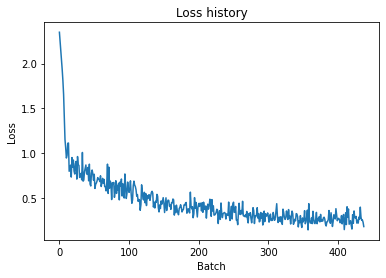

In [ ]:
import matplotlib.pyplot as plt
# plot the training loss history

loss_train = [val.item() for val in train_loss_history]
val_train = [val.item() for val in val_loss_history]
fig, ax = plt.subplots()
ax.plot(loss_train, label = 'train')
ax.set_title('Loss history')
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
ax.plot(val_train, label = 'val')
ax.legend()
plt.savefig(os.path.join("out", "loss_curve_" + classifier + ".png"))

In [ ]:
train_loss_history

[tensor(2.3482, grad_fn=<DivBackward0>),
 tensor(2.2466, grad_fn=<DivBackward0>),
 tensor(2.1579, grad_fn=<DivBackward0>),
 tensor(2.0550, grad_fn=<DivBackward0>),
 tensor(1.9317, grad_fn=<DivBackward0>),
 tensor(1.8096, grad_fn=<DivBackward0>),
 tensor(1.6553, grad_fn=<DivBackward0>),
 tensor(1.4027, grad_fn=<DivBackward0>),
 tensor(1.1540, grad_fn=<DivBackward0>),
 tensor(1.0616, grad_fn=<DivBackward0>),
 tensor(0.9482, grad_fn=<DivBackward0>),
 tensor(0.9775, grad_fn=<DivBackward0>),
 tensor(1.1122, grad_fn=<DivBackward0>),
 tensor(1.1152, grad_fn=<DivBackward0>),
 tensor(0.8002, grad_fn=<DivBackward0>),
 tensor(0.8336, grad_fn=<DivBackward0>),
 tensor(0.8685, grad_fn=<DivBackward0>),
 tensor(0.7359, grad_fn=<DivBackward0>),
 tensor(0.9532, grad_fn=<DivBackward0>),
 tensor(0.8472, grad_fn=<DivBackward0>),
 tensor(0.9259, grad_fn=<DivBackward0>),
 tensor(0.8022, grad_fn=<DivBackward0>),
 tensor(0.7698, grad_fn=<DivBackward0>),
 tensor(0.8853, grad_fn=<DivBackward0>),
 tensor(0.9103, 

In [35]:
print(type(shuffled_train["ner_tags"]))
print(type(shuffled_train["ner_tags"][0]))
shuffled_train["ner_tags"][0]

<class 'list'>
<class 'list'>


[0, 0]

## 3. Creating an LSTM with ```pytorch```

In the file [LSTM.py](../src/LSTM.py), I've aready created an LSTM for you using ```pytorch```. Take some time to read through the code and make sure you understand how it's built up.

Some questions for you to discuss in groups:

- How is an LSTM layer created using ```pytorch```? How does the code compare to the classifier code you wrote last week?
- What's going on with that weird bit that says ```@staticmethod```?
  - [This might help](https://realpython.com/instance-class-and-static-methods-demystified/).
- On the forward pass, we use ```log_softmax()``` to make output predictions. What is this, and how does it relate to the output from the sigmoid function that we used in the document classification?
  * Answer: Log Softmax is advantageous over softmax for numerical stability, optimisation and heavy penalisation for highly incorrect class
- How would we make this LSTM model *bidirectional* - i.e. make it a Bi-LSTM? 
  - Hint: Check the documentation for the LSTM layer on the ```pytorch``` website.
  * Answer: to apply the LSTM layer for both the words before and after the one we for example want to predict the ner tag for we simply set bi-directional = True